In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

## Election Results

Election results are from Oklahoma State Election Board (https://results.okelections.us/OKER/?elecDate=20181106).

## Shape Files
Precinct shapefile from Oklahoma GIS Data Warehouse (https://csagis-uok.opendata.arcgis.com/).

RDH note: shapefile for GIS data warehouse here: https://csagis-uok.opendata.arcgis.com/datasets/c83b09af406d48f7bbca30942fe186a8_0/explore?location=35.317799%2C-98.716567%2C8.77

## Processing
Early votes were reported countywide for Oklahoma County and Tulsa County. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

## Races

- G18GOVRSTI - Kevin Stitt (Republican Party)
- G18GOVDEDM - Drew Edmondson (Democratic Party)
- G18GOVLPOW - Chris Powell (Libertarian Party)


- G18LTGRPIN - Matt Pinnell (Republican Party)
- G18LTGDPIT - Anastasia A. Pittman (Democratic Party)
- G18LTGIHOL - Ivan Holmes (Independent)


- G18ATGRHUN - Mike Hunter (Republican Party)
- G18ATGDMYL - Mark Myles (Democratic Party)


- G18TRERMCD - Randy McDaniel (Republican Party)
- G18TREICOU - Charles de Coune (Independent)


- G18AUDRBYR - Cindy Byrd (Republican Party)
- G18AUDLYEU - John Yeutter (Libertarian Party)


- G18LABROSB - Leslie Osborn (Republican Party)
- G18LABDDOR - Fred Dorrell (Democratic Party)
- G18LABIDIS - Brandt Dismukes (Independent)


- G18COCRANT - Bob Anthony (Republican Party)
- G18COCDMCC - Ashley Micole McCray (Democratic Party)
- G18COCISHO - Jackie Short (Independent)


- G18INSRMUL - Glen Mulready (Republican Party)
- G18INSDFOB - Kimberly Fobbs (Democratic Party)


- G18SPIRHOF - Joy Hofmeister (Republican Party)
- G18SPIDCOX - John Cox (Democratic Party)
- G18SPIIHUF - Larry Huff (Independent)


# Precinct Shapefile

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/vest-2018/ok_2018.shp")

In [3]:
vest_shp.shape

(1951, 27)

In [4]:
vest_shp.head()


,COUNTY,PRECINCT,PCT_CEB,G18GOVRSTI,G18GOVDEDM,G18GOVLPOW,G18LTGRPIN,G18LTGDPIT,G18LTGIHOL,G18ATGRHUN,...,G18LABIDIS,G18COCRANT,G18COCDMCC,G18COCISHO,G18INSRMUL,G18INSDFOB,G18SPIRHOF,G18SPIDCOX,G18SPIIHUF,geometry
0,01,1,010001,165,99,16,180,80,14,192,...,16,166,88,16,182,88,131,127,21,"POLYGON ((-94.62595 35.77919, -94.62591 35.777..."
1,01,2,010002,164,73,5,169,58,14,177,...,8,158,68,12,167,69,148,75,19,"POLYGON ((-94.72330 35.79789, -94.72202 35.797..."
2,01,3,010003,83,37,8,89,30,9,90,...,9,78,37,13,88,40,73,36,18,"POLYGON ((-94.72479 36.02797, -94.72449 36.027..."
3,01,5,010005,129,57,10,141,45,9,142,...,14,133,53,7,129,61,103,79,13,"POLYGON ((-94.72595 35.80642, -94.72595 35.806..."
4,01,6,010006,236,156,19,260,132,13,296,...,15,250,135,16,251,151,207,183,19,"POLYGON ((-94.66412 35.90763, -94.66417 35.907..."


<AxesSubplot:>

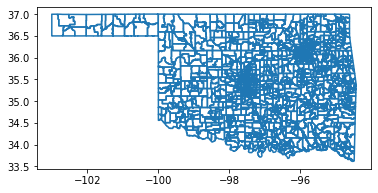

In [5]:
vest_shp.boundary.plot()

<AxesSubplot:>

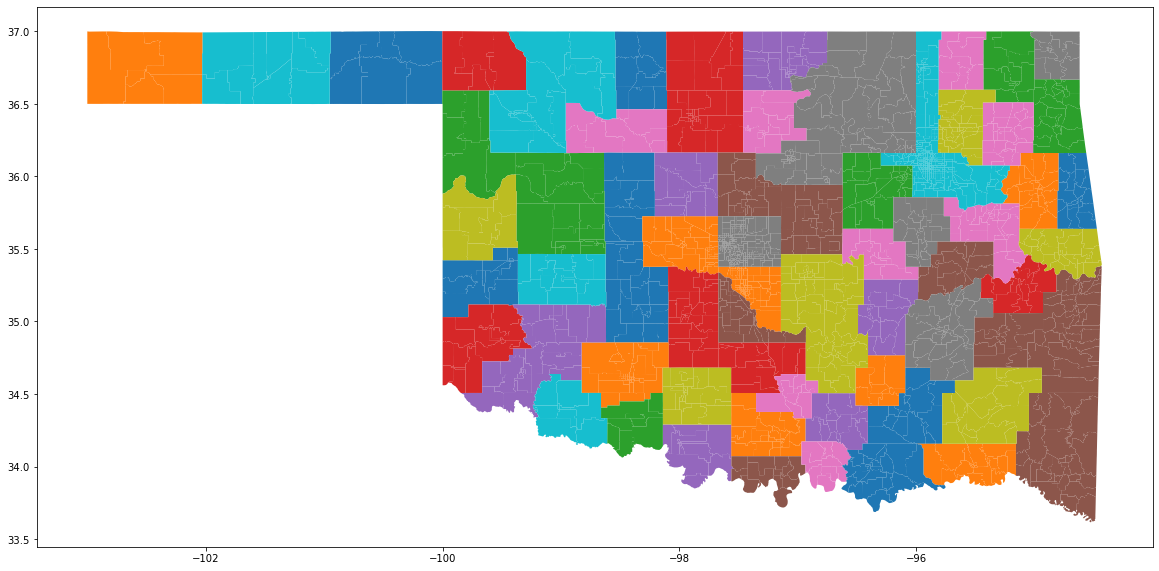

In [6]:
vest_shp.plot(column='COUNTY', figsize=(20,20))

In [7]:
vest_shp.columns

Index(['COUNTY', 'PRECINCT', 'PCT_CEB', 'G18GOVRSTI', 'G18GOVDEDM',
       'G18GOVLPOW', 'G18LTGRPIN', 'G18LTGDPIT', 'G18LTGIHOL', 'G18ATGRHUN',
       'G18ATGDMYL', 'G18TRERMCD', 'G18TREICOU', 'G18AUDRBYR', 'G18AUDLYEU',
       'G18LABROSB', 'G18LABDDOR', 'G18LABIDIS', 'G18COCRANT', 'G18COCDMCC',
       'G18COCISHO', 'G18INSRMUL', 'G18INSDFOB', 'G18SPIRHOF', 'G18SPIDCOX',
       'G18SPIIHUF', 'geometry'],
      dtype='object')

## Load the SOS Election Results File

In [8]:
ok_18 = pd.read_csv("raw-from-source/ok-2018/20181106_PrecinctResults.csv", index_col=False)

In [9]:
ok_18.head()

,elec_date,precinct,entity_description,race_number,race_description,race_party,tot_race_prec,race_prec_reporting,cand_number,cand_name,cand_party,cand_absmail_votes,cand_early_votes,cand_elecday_votes,cand_tot_votes,race_county_owner
0,11/6/2018,10001,"FEDERAL, STATE AND COUNTY",10001,FOR GOVERNOR,NaN,1951,1951,1,CHRIS POWELL,LIB,0,2,14,16,NaN
1,11/6/2018,10001,"FEDERAL, STATE AND COUNTY",10001,FOR GOVERNOR,NaN,1951,1951,2,KEVIN STITT,REP,7,10,148,165,NaN
2,11/6/2018,10001,"FEDERAL, STATE AND COUNTY",10001,FOR GOVERNOR,NaN,1951,1951,3,DREW EDMONDSON,DEM,0,7,92,99,NaN
3,11/6/2018,10001,"FEDERAL, STATE AND COUNTY",10002,FOR LIEUTENANT GOVERNOR,NaN,1951,1951,1,MATT PINNELL,REP,7,11,162,180,NaN
4,11/6/2018,10001,"FEDERAL, STATE AND COUNTY",10002,FOR LIEUTENANT GOVERNOR,NaN,1951,1951,2,ANASTASIA A. PITTMAN,DEM,0,7,73,80,NaN


In [10]:
ok_18.shape

(132473, 16)

## Clean Up the Elections Results

In [11]:
#filter rows with presidential, Senatorial, and Corporate Commissioner results
filtered_18 = ok_18.loc[(ok_18['race_description']== 'FOR ATTORNEY GENERAL') 
                        | (ok_18['race_description']== 'FOR COMMISSIONER OF LABOR') 
                        | (ok_18['race_description']== 'FOR CORPORATION COMMISSIONER')
                        | (ok_18['race_description']== 'FOR GOVERNOR')
                        | (ok_18['race_description']== 'FOR INSURANCE COMMISSIONER')
                        | (ok_18['race_description']== 'FOR LIEUTENANT GOVERNOR')
                        | (ok_18['race_description']== 'FOR STATE AUDITOR AND INSPECTOR')
                        | (ok_18['race_description']== 'FOR STATE TREASURER')
                        | (ok_18['race_description']== 'FOR SUPERINTENDENT OF PUBLIC INSTRUCTION')]
filtered_18.reset_index(drop=True, inplace = True)
#filtered_20.to_csv('filtered.csv')
ok_unq = filtered_18['race_description'].value_counts()
#print(ok_unq)


In [12]:

#dropping info
filtered_df = filtered_18.drop(['cand_absmail_votes','cand_early_votes','cand_elecday_votes','tot_race_prec','race_prec_reporting','race_county_owner','elec_date','entity_description','race_party','cand_number','cand_party'], axis=1)



In [13]:
#pivoting based on cand_name and precinct vote totals
pivot_df = pd.pivot_table(filtered_df, index = 'precinct', columns = 'cand_name', values="cand_tot_votes")
#print(pivot_df)
#dropping and renaming columns to match VEST
pivot_df = pivot_df.rename(columns={'KEVIN STITT':'G18GOVRSTI',
                                    'DREW EDMONDSON':'G18GOVDEDM',
                                    'CHRIS POWELL':'G18GOVLPOW',
                                    'MATT PINNELL':'G18LTGRPIN',
                                    'ANASTASIA A. PITTMAN':'G18LTGDPIT',
                                    'IVAN HOLMES':'G18LTGIHOL',
                                    'MIKE HUNTER':'G18ATGRHUN',
                                    'MARK MYLES':'G18ATGDMYL',
                                    'RANDY McDANIEL':'G18TRERMCD',
                                    'CHARLES de COUNE':'G18TREICOU',
                                    'CINDY BYRD':'G18AUDRBYR',
                                    'JOHN YEUTTER':'G18AUDLYEU',
                                    'LESLIE OSBORN':'G18LABROSB',
                                    'FRED DORRELL':'G18LABDDOR',
                                    'BRANDT DISMUKES':'G18LABIDIS',
                                    'BOB ANTHONY':'G18COCRANT',
                                    'ASHLEY NICOLE McCRAY':'G18COCDMCC',
                                    'JACKIE SHORT':'G18COCISHO',
                                    'GLEN MULREADY':'G18INSRMUL',
                                    'KIMBERLY FOBBS':'G18INSDFOB',
                                    'JOY HOFMEISTER':'G18SPIRHOF',
                                    'JOHN COX':'G18SPIDCOX',
                                    'LARRY HUFF':'G18SPIIHUF'})
pivot_df = pivot_df[['G18GOVRSTI','G18GOVDEDM','G18GOVLPOW','G18LTGRPIN','G18LTGDPIT','G18LTGIHOL','G18ATGRHUN','G18ATGDMYL','G18TRERMCD','G18TREICOU','G18AUDRBYR','G18AUDLYEU','G18LABROSB','G18LABDDOR','G18LABIDIS','G18COCRANT','G18COCDMCC','G18COCISHO','G18INSRMUL','G18INSDFOB','G18SPIRHOF','G18SPIDCOX','G18SPIIHUF']]
pivot_df.reset_index(inplace=True)


## Adding FIPS number

Election results had FIPS joined to the 'precinct' column with first two digits being the county FIPS number. The election results are numbered 1,2,3.... etc. National County Fips are every odd number and RDH updated that number from the elections results. Additionally we added leading zeroes to STR and matched it to national FIPS database.

In [14]:
#uploading national FIPS codes to apply back to file
FIPS = pd.read_csv('./raw-from-source/FIPS/US_FIPS_Codes.csv')
FIPS = FIPS[FIPS['State'] == 'Oklahoma']
FIPS1 = FIPS.drop(['State','FIPS State'],axis=1)

#adding leading zeroes to FIPS data
FIPS1['FIPS County'] = FIPS1['FIPS County'].apply(lambda x:'{0:0>3}'.format(x))
FIPS1.reset_index(inplace=True)
FIPS1 = FIPS1.drop(['index'],axis=1)
#print(FIPS1)
# changing FIPS county type to str taking first two characters, selecting only the first 162 rows which need to have zeroes removed
df_1 = pivot_df['precinct'].astype(str).str[:2]
df_3 = df_1.iloc[:163]

#replace all trailing zeroes with blank and create new dataframe with FIPS codes
df_2 = []
for string in df_3:
    df_3 = string.replace("0", "")
    df_2.append(df_3)

# rejoining dataframe to itself
df = pd.DataFrame(df_2)
df_append = df_1.iloc[163:]
#print(df_append)
dataframes = [df, df_append]
df = pd.concat(dataframes)
# Rename first column, convert county code to national FIPS #, add leading zeroes
df.rename( columns={0 :'FIPS County'}, inplace=True )
df.loc[(df['FIPS County']=='81') ,"FIPS County"] = '8'
df['FIPS County'] = df.astype(int)*2-1
df['FIPS County'].astype(str).apply(lambda x:'{0:0>3}'.format(x))
pivot_df['FIPS County'] = df['FIPS County'].astype(str).apply(lambda x:'{0:0>3}'.format(x))
#print(pivot_df)

In [15]:
#adding FIPS to vest file
pivot_df = pivot_df.merge(FIPS1, how='left', on='FIPS County')


In [16]:
#modifying FIPS number
vest_shp['COUNTY'] = vest_shp['COUNTY'].astype(int)*2-1
vest_shp['FIPS COUNTY'] = vest_shp['COUNTY'].astype(str).apply(lambda x:'{0:0>3}'.format(x))


In [17]:
#add leading zeroes to county column 
vest_shp['COUNTY'] = vest_shp['COUNTY'].astype(str).apply(lambda x:'{0:0>3}'.format(x))

## Validate Elections Results

In [18]:
#statewide vote total check
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [19]:
column_list = ['G18GOVRSTI','G18GOVDEDM','G18GOVLPOW','G18LTGRPIN','G18LTGDPIT','G18LTGIHOL','G18ATGRHUN','G18ATGDMYL','G18TRERMCD','G18TREICOU','G18AUDRBYR','G18AUDLYEU','G18LABROSB','G18LABDDOR','G18LABIDIS','G18COCRANT','G18COCDMCC','G18COCISHO','G18INSRMUL','G18INSDFOB','G18SPIRHOF','G18SPIDCOX','G18SPIIHUF']
statewide_totals_check(vest_shp, pivot_df, column_list)

***Statewide Totals Check***
G18GOVRSTI is equal 	VEST / RDH: 644579
G18GOVDEDM is equal 	VEST / RDH: 500973
G18GOVLPOW is equal 	VEST / RDH: 40833
G18LTGRPIN is equal 	VEST / RDH: 729219
G18LTGDPIT is equal 	VEST / RDH: 406797
G18LTGIHOL is equal 	VEST / RDH: 42174
G18ATGRHUN is equal 	VEST / RDH: 750769
G18ATGDMYL is equal 	VEST / RDH: 421699
G18TRERMCD is equal 	VEST / RDH: 779657
G18TREICOU is equal 	VEST / RDH: 309525
G18AUDRBYR is equal 	VEST / RDH: 818851
G18AUDLYEU is equal 	VEST / RDH: 270313
G18LABROSB is equal 	VEST / RDH: 717765
G18LABDDOR is equal 	VEST / RDH: 389249
G18LABIDIS is equal 	VEST / RDH: 55823
G18COCRANT is equal 	VEST / RDH: 701279
G18COCDMCC is equal 	VEST / RDH: 400634
G18COCISHO is equal 	VEST / RDH: 66282
G18INSRMUL is equal 	VEST / RDH: 720077
G18INSDFOB is equal 	VEST / RDH: 441925
G18SPIRHOF is equal 	VEST / RDH: 687468
G18SPIDCOX is equal 	VEST / RDH: 396901
G18SPIIHUF is equal 	VEST / RDH: 90510


In [20]:
#Checks county level results
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [21]:
#county_col = name of counties needed to compare
vest_shp = vest_shp.dropna()
vest_shp['FIPS County'] = vest_shp['COUNTY']
county_totals_check(vest_shp, pivot_df,column_list, "FIPS County")

***Countywide Totals Check***

G18GOVRSTI is equal across all counties
G18GOVDEDM is equal across all counties
G18GOVLPOW is equal across all counties
G18LTGRPIN is equal across all counties
G18LTGDPIT is equal across all counties
G18LTGIHOL is equal across all counties
G18ATGRHUN is equal across all counties
G18ATGDMYL is equal across all counties
G18TRERMCD is equal across all counties
G18TREICOU is equal across all counties
G18AUDRBYR is equal across all counties
G18AUDLYEU is equal across all counties
G18LABROSB is equal across all counties
G18LABDDOR is equal across all counties
G18LABIDIS is equal across all counties
G18COCRANT is equal across all counties
G18COCDMCC is equal across all counties
G18COCISHO is equal across all counties
G18INSRMUL is equal across all counties
G18INSDFOB is equal across all counties
G18SPIRHOF is equal across all counties
G18SPIDCOX is equal across all counties
G18SPIIHUF is equal across all counties


In [22]:
#Allocate Absentee Precincts
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [23]:
# calling function and creating fields not in aggregate Absentee Precincts

absentee_votes = pivot_df[pivot_df["precinct"].isin([559999,729999])]
precinct_votes = pivot_df[~pivot_df["precinct"].isin([559999,729999])]
allocated_df = allocate_absentee(precinct_votes, absentee_votes, column_list,"FIPS County")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

## Join

In [24]:
#set to string and set leading zeroes then merge based on ID
vest_shp["unique_ID"] = vest_shp["PCT_CEB"].astype(str)
allocated_df["unique_ID"] = allocated_df["precinct"].astype(str)
allocated_df['unique_ID'] = allocated_df['unique_ID'].astype(str).apply(lambda x:'{0:0>6}'.format(x))
join_1 = pd.merge(allocated_df, vest_shp, how="outer",on='unique_ID', indicator = True, validate="1:1")
join_1["_merge"].value_counts()

<ipython-input-24-cf667081b4d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_df["unique_ID"] = allocated_df["precinct"].astype(str)
<ipython-input-24-cf667081b4d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_df['unique_ID'] = allocated_df['unique_ID'].astype(str).apply(lambda x:'{0:0>6}'.format(x))


both          1951
left_only        0
right_only       0
Name: _merge, dtype: int64

In [25]:
#Checks individual precinct level
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [26]:
#vest_on_left = boolean logic which is TRUE if VEST/MGGG data is on left side of columns FALSE if VEST/MGGG data is on right
#name_col literally the column header with the precinct names without a dataframe
precinct_votes_check(join_1, column_list, False, 'precinct')


There are  1951  total rows
0  of these rows have election result differences
1951  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
